In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Group all datasets

In [2]:
reviews = pd.read_csv('airbnb_last_review.tsv', delimiter = '\t')
types = pd.read_excel('airbnb_room_type.xlsx', sheet_name = 'airbnb_room_type')
price = pd.read_csv('airbnb_price.csv')

data = pd.merge(pd.merge(reviews, types, on = 'listing_id'), price, on = 'listing_id')
print(data.shape)

display(data.head())

print(data.info())



(25209, 7)


,listing_id,host_name,last_review,description,room_type,price,nbhood_full
0,2595,Jennifer,May 21 2019,Skylit Midtown Castle,Entire home/apt,225 dollars,"Manhattan, Midtown"
1,3831,LisaRoxanne,July 05 2019,Cozy Entire Floor of Brownstone,Entire home/apt,89 dollars,"Brooklyn, Clinton Hill"
2,5099,Chris,June 22 2019,Large Cozy 1 BR Apartment In Midtown East,Entire home/apt,200 dollars,"Manhattan, Murray Hill"
3,5178,Shunichi,June 24 2019,Large Furnished Room Near B'way,private room,79 dollars,"Manhattan, Hell's Kitchen"
4,5238,Ben,June 09 2019,Cute & Cozy Lower East Side 1 bdrm,Entire home/apt,150 dollars,"Manhattan, Chinatown"


<class 'pandas.core.frame.DataFrame'>
Int64Index: 25209 entries, 0 to 25208
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   listing_id   25209 non-null  int64 
 1   host_name    25201 non-null  object
 2   last_review  25209 non-null  object
 3   description  25199 non-null  object
 4   room_type    25209 non-null  object
 5   price        25209 non-null  object
 6   nbhood_full  25209 non-null  object
dtypes: int64(1), object(6)
memory usage: 1.5+ MB
None


## Data Cleaning

### Missing values

Filling the missing values of host_name and description with null values.

In [3]:
data['host_name'].fillna('null', inplace=True)
data['description'].fillna('null', inplace=True)

### nbhood_full and price

Clean data with extra information

In [4]:
# Separate nhbood_full into district and nbhood
data['district'] = data['nbhood_full'].str.split(',').str[0]
data['nbhood'] = data['nbhood_full'].str.split(',').str[1]

# Clean price column
data['price'] = data['price'].str.split(' ').str[0].astype(int)

### room_type

In [5]:
map = {'Entire home/apt' : 'apt',
        'entire home/apt': 'apt',
        'ENTIRE HOME/APT': 'apt',
        'Private room' : 'room',
        'private room' : 'room',
        'PRIVATE ROOM' : 'room',
        'Shared room' : 'shared',
        'shared room' : 'shared',
        'SHARED ROOM' : 'shared',}

data['room_type'] = data['room_type'].replace(map)
data['room_type'].unique()


array(['apt', 'room', 'shared'], dtype=object)

### Free Listings

Some of these are marked as free. We need to remove them.

In [6]:
free_listings = data['price'] == 0
data = data[~free_listings]

## Feature Engineering

### description

For the description, there are many different ways of conveying how good is a room and a personalized classification system would be unthinkable. So since TfidfVectorizer already cleans the data by turning everything to lower case and separating by spaces and markers we just have to use the bag of words method.

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer

data.reset_index(drop=True, inplace=True)

# The description column is giving problems, so we'll turn everything to string
data['description'] = data['description'].apply(lambda x: np.str_(x))

# Vectorize
vectorizer = TfidfVectorizer()
bag_of_words = vectorizer.fit_transform(data['description'])
bag_of_words_df = pd.DataFrame(bag_of_words.toarray(), columns=vectorizer.get_feature_names_out())


In [8]:
# Check only those with high correlation with the price
correlations = bag_of_words_df.corrwith(data['price'])

good_words_index = correlations > 0.05
good_words = list(correlations[good_words_index].index)

data = pd.concat([data, bag_of_words_df[good_words]], axis=1)

# It is taking 1GB of memory, so we'll clear it
del bag_of_words_df, bag_of_words, correlations

### last_review

All of the apartments are from 2019, so we will only extract the month from the last review.

In [9]:
data['last_review_month'] = data['last_review'].str.split(' ').str[0].astype(str)

### host_name

Moreover, we'll categorize the names by female, male, and undetermined.

In [10]:
import gender_guesser.detector as gender

guesser = gender.Detector()

map_gender = {'male':'Male',
                'mostly_male':'Male',
                'female':'Female',
                'mostly_female':'Female',
                'andy':'Undetermined',
                'unknown':'Undetermined'}
# Guess genders
data['gender'] = data['host_name'].apply(lambda name: guesser.get_gender(name))

# Collapse the categories
data['gender'].replace(map_gender, inplace = True)

### Remove Columns

Finally, consider only columns we want. We'll drop:
- listing_id, host_name, last_review, description

since they were modified or have small correlation with the price

In [11]:
data.drop(columns = ['listing_id', 'host_name', 'last_review', 'description'], axis = 1, inplace = True)

## Analysis

We'll first take a look at an the overall NYC prices. The mean is around 140 while the median is 105. As we'll see later, there are a lot of outliers, which explain this difference between mean and median.

In [12]:
price_mean = data['price'].mean()
price_median = data['price'].median()

print('The mean price of an Airbnb in NYC is: ', price_mean)
print('The median price of an Airbnb in NYC is: ', price_median)

The mean price of an Airbnb in NYC is:  141.81731608602493
The median price of an Airbnb in NYC is:  105.0


According to Zumper website, the average monthly rent in NYC is $3,987.

In [13]:
print('The monthly average price of the Airbnb is: ', price_mean * 365 / 12)
print('The monthly median price of the Airbnb is: ', price_median * 365 / 12)

The monthly average price of the Airbnb is:  4313.610030949925
The monthly median price of the Airbnb is:  3193.75


### Price by borough

We'll start by analyzing which districts are the most expensive. Some houses have exorbitant prices which represent outliers. We'll consider a plot without them

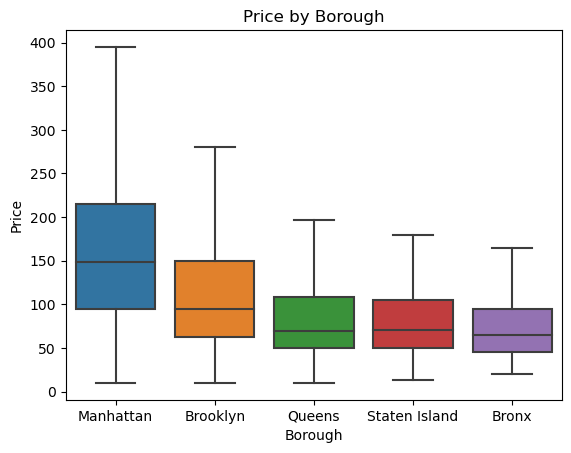

In [14]:
sns.boxplot(data = data, x = 'district', y = 'price', showfliers = False)
plt.xlabel('Borough')
plt.ylabel('Price')
plt.title('Price by Borough')
plt.show()

From most to least expensive we have:
1. Manhattan
2. Brooklyn
3. Queens
4. Staten Island
5. Bronx

Aside from being some of the most expensive, Manhattan and Brooklyn have also the most outliers and where the prices tend to vary most.

In [15]:
def count_outliers(values):
    """
    Count the number of outliers in a column of a dataframe.
    """
    q1 = values.quantile(0.25)
    q3 = values.quantile(0.75)
    iqr = q3 - q1
    outliers = values[(values < (q1 - 1.5 * iqr)) | (values > (q3 + 1.5 * iqr))]
    return outliers.shape[0]

n_outliers = data.groupby('district')['price'].agg([count_outliers, np.std])
display(n_outliers)

,count_outliers,std
district,,
Bronx,34,58.051225
Brooklyn,526,123.958970
Manhattan,689,178.181024
Queens,249,78.514658
Staten Island,17,54.624606


### Gender impact

We can also evaluate how does gender affect one's preference to rent a room in airbnb. 

*Note: since name and gender is not always related and have a subjective component for which the methods used to guess gender by names does not always account for. Hence, it must not be taken too seriously.*

We can see that overall female have more or almost equal AirBnb housing than men, with the exception of Manhattan where male hosts are predominant. 

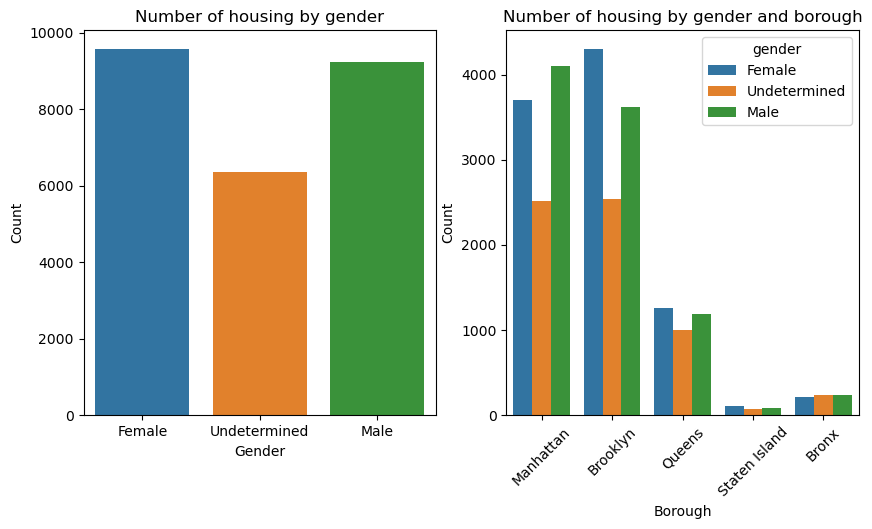

In [16]:
fig, ax = plt.subplots(1, 2, figsize = (10, 5))


sns.countplot(data = data, x = 'gender', ax = ax[0])
ax[0].set_title('Number of housing by gender')
ax[0].set_xlabel('Gender')
ax[0].set_ylabel('Count')

sns.countplot(data = data, x = 'district', hue = 'gender', ax = ax[1])
ax[1].set_title('Number of housing by gender and borough')
ax[1].tick_params(axis = 'x', labelrotation=45)
ax[1].set_xlabel('Borough')
ax[1].set_ylabel('Count')
plt.show()


Regarding price, it does not seem that any gender has any particular bias for higher pricing.

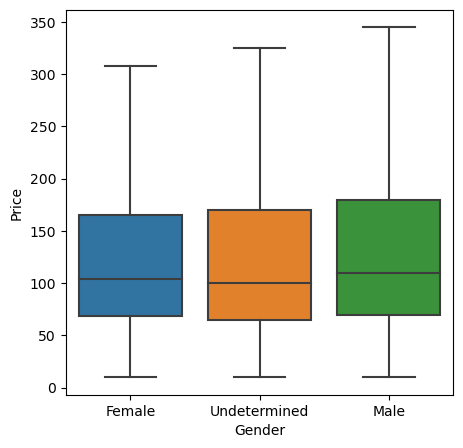

In [17]:
fig, ax = plt.subplots(figsize = (5, 5))

sns.boxplot(data = data, x = 'gender', y = 'price', showfliers = False)
ax.set_xlabel('Gender')
ax.set_ylabel('Price')

plt.show()

### Price by type

The prices seem to follow the trends previously seen. We also see that, as expected, apartments are the most expensive, followed by private rooms and then shared ones. However, as we can see in the box plot, there are shared rooms in Manhatann that are the same price as apartments in the Bronx.

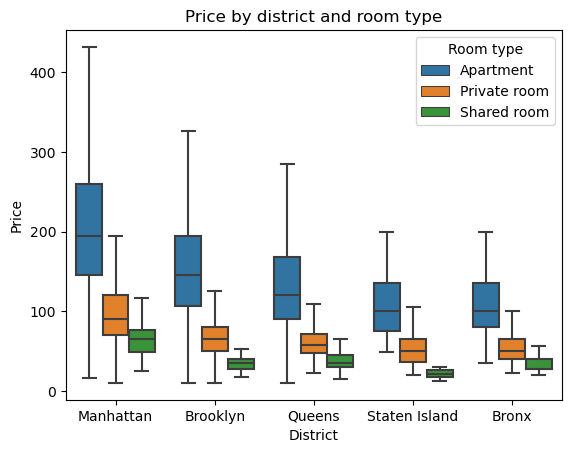

In [18]:
g = sns.boxplot(data = data, x = 'district', y = 'price', hue = 'room_type', showfliers = False)

g.set_title('Price by district and room type')
g.set_xlabel('District')
g.set_ylabel('Price')

handles, labels = g.get_legend_handles_labels()

g.legend(handles = handles, 
        labels = ['Apartment', 'Private room', 'Shared room'], 
        title = 'Room type')

plt.show()

### Location plot

We're using Nominatim in the geopy library to get coordinates of places. However there were a few instances where it couldn't do it, but since they were not much, I just hand searched them on google maps. It is saved under 'geocoordinates.json'.

In [19]:
####### This code is for saving the geolocation in a dictionary

# from geopy.geocoders import Nominatim

# # Encode names into coordinates
# geolocator = Nominatim(user_agent="your_app_name")
# geolocation = {}

# for place in data['nbhood_full'].unique():
#     count = 0
#     while place not in geolocation.keys():
#         if count == 5:
#             break
#         count += 1
#         print(place)
#         try:
#             geo = geolocator.geocode(place)
#             geolocation[place] = (geo.latitude, geo.longitude)
#         except:
#             continue

# # The ones left are the following 

# # {'Bronx, Claremont Village',
# #  'Bronx, North Riverdale',
# #  'Queens, Jamaica Hills',
# #  "Staten Island, Bull's Head",
# #  'Staten Island, Lighthouse Hill',
# #  'Staten Island, Randall Manor'}

# missing = set(data['nbhood_full'].unique()) - set(geolocation.keys())

# geolocation['Bronx, Claremont Village'] = (40.8334, -73.9005)
# geolocation['Bronx, North Riverdale'] = (40.9036, -73.9055)
# geolocation['Queens, Jamaica Hills'] = (40.7128, -73.7970)
# geolocation["Staten Island, Bull's Head"] = (40.6082, -74.1550)
# geolocation['Staten Island, Lighthouse Hill'] = (40.6012, -74.1357)
# geolocation['Staten Island, Randall Manor'] = (40.6376, -74.1044)

# # These were retrieved but are not correct

# geolocation['Queens, Bay Terrace'] = (40.7756, -73.7797)
# geolocation['Bronx, West Farms'] = (40.8433, -73.8811)



# import json

# # Specify the file path
# file_path = 'geocoordinates.json'

# # Write the dictionary to the JSON file
# with open(file_path, 'w') as file:
#     json.dump(geolocation, file)

#########################################################################################################

####### This code is for loading the geolocation from a dictionary
import json

file_path = 'geocoordinates.json'
with open(file_path, 'r') as file:
    geolocation = json.load(file)

In [20]:
# Get latiture and longitude
data['coordinates'] = data['nbhood_full'].apply(lambda x: geolocation[x])
data['latitude'] = data['coordinates'].apply(lambda x: x[0])
data['longitude'] = data['coordinates'].apply(lambda x: x[1])

Now, we plot the coordinates and we should see the city of New York. Let's, however, plot it without outliers.

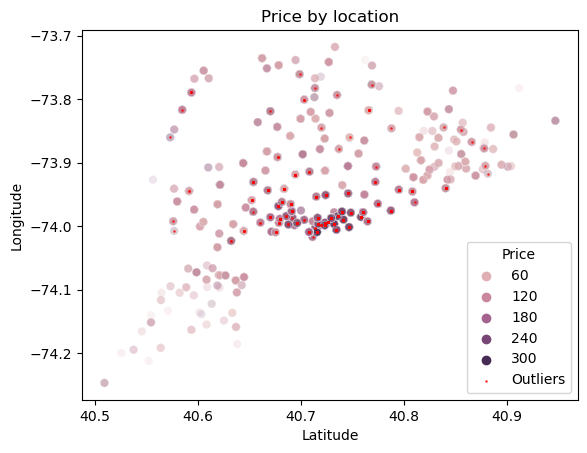

In [21]:
# Calculate outliers 
q1 = data['price'].quantile(0.25)
q3 = data['price'].quantile(0.75)
iqr = q3 - q1

outliers = data[data['price'] > q3 + 1.5*iqr]
outliers_lat = outliers['latitude']
outliers_lon = outliers['longitude']

data['price_capped'] = data['price'].apply(lambda x: q3 + 1.5*iqr if x > q3 + 1.5*iqr else x)
    
# Plot
g = sns.scatterplot(data = data, x = 'latitude', y = 'longitude', hue = 'price_capped', alpha = 0.15)
g.scatter(outliers_lat, outliers_lon, c = 'red', alpha = 0.6, s = 1, label = 'Outliers')
g.set_title('Price by location')
g.set_xlabel('Latitude')
g.set_ylabel('Longitude')
g.legend(title = 'Price')

plt.show()

## Predicting prices

We will try and predict prices according to our features. Here's the treatment that will follow:
- room_type: Ordinal encoding, since there is an order of 'quality'
- price_capped: We're choosing these as a label instead of the original prices since the price depends strongly on the particularities of the apartment
- nbhood_full: Drop
- district, nbhood: One Hot Encode
- last_review_month: One Hot Encode
- gender: One Hot Encode
- coordinates: drop since we'll have longitude and latitude
- price_capped: drop


In [22]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error

### Processing

In [23]:
cols_to_drop = ['price', 'price_capped', 'nbhood_full', 'coordinates']
X = data.drop(cols_to_drop, axis = 1)
y = data['price_capped']

In [24]:
cols_one_hot = ['nbhood', 'district', 'last_review_month', 'gender']
cols_ordinal = ['room_type']
cols_scaler = ['latitude', 'longitude']

onehot = OneHotEncoder()
ordinal = OrdinalEncoder(categories = [['apt', 'room', 'shared']])
scaler = StandardScaler()

transformer = ColumnTransformer([ 
    ('onehot', onehot, cols_one_hot),
    ('ordinal', ordinal, cols_ordinal),
    ('scaler', scaler, cols_scaler)
], remainder='passthrough')

# The result is a sparse matrix, which we'll turn to a DataFrame
X_trans_sparse = transformer.fit_transform(X)

from scipy.sparse import csr_matrix

X_trans_array = X_trans_sparse.toarray()
X_trans = pd.DataFrame(X_trans_array)


### Separate test from train

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X_trans, y, test_size=0.2, random_state=42)

- SCORE: We will use RMSE since it gives essentially the same weight to the differences
- BASELINE: Linear Regression for: Explainability, Simplicity, Efficiency, Speed
- MODEL: Random Forest for: Complexity and Simplicity, Ability to capture non-linear trends, Speed, Explainability

### Baseline

In [26]:
from sklearn.linear_model import LinearRegression

linear = LinearRegression()

linear_scores = cross_val_score(linear, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
linear_rmse_scores = np.sqrt(-linear_scores)
linear_score_mean = linear_rmse_scores.mean()

print('Linear Regression RMSE Scores: ', linear_rmse_scores)
print('Linear Regression RMSE: ', linear_score_mean)

Linear Regression RMSE Scores:  [4.38027243e+11 2.04762165e+11 8.25331501e+11 1.78671294e+11
 1.59540999e+12]
Linear Regression RMSE:  648440439122.5886


### Model

### Random Forest

In [27]:
from sklearn.ensemble import RandomForestRegressor

forest = RandomForestRegressor(n_estimators=100, random_state=42)

forest_scores = cross_val_score(forest, X_train, y_train, cv = 5, scoring = "neg_mean_squared_error")
forest_rmse_scores = np.sqrt(-forest_scores)
forest_scores_mean = forest_rmse_scores.mean()

print("Random Forest Regressor RMSE Scores: ", forest_rmse_scores)
print("Random Forest Regressor RMSE: ", forest_scores_mean)


Random Forest Regressor RMSE Scores:  [56.86708678 56.58782888 56.03323326 55.69652944 54.97761301]
Random Forest Regressor RMSE:  56.0324582715063


### Suport Vector

In [28]:
from sklearn.svm import SVR

svr = SVR(C = 1, gamma = 0.1, kernel = 'rbf')

svr_scores = cross_val_score(svr, X_train, y_train, cv=5, scoring = 'neg_mean_squared_error')
svr_rmse_scores = np.sqrt(-svr_scores)
svr_scores_mean = svr_rmse_scores.mean()

print('SVR RMSE Scores: ', svr_rmse_scores)
print('SVR RMSE: ', svr_scores_mean)

SVR RMSE Scores:  [61.6161233  60.66350674 57.86922226 59.09398327 58.75017677]
SVR RMSE:  59.59860246674208


## TESTING

In [29]:
from sklearn.metrics import r2_score

linear.fit(X_train, y_train)
predicted_linear = linear.predict(X_test)
test_scores_linear = mean_squared_error(y_test, predicted_linear, squared=False)
test_r2scores_linear = r2_score(predicted_linear, y_test)
print('Testing Linear Regression RMSE: ', test_scores_linear)
print('Testing Linear Regression R2: ', test_r2scores_linear)

forest.fit(X_train, y_train)
predicted_forest = forest.predict(X_test)
test_scores_forest = mean_squared_error(y_test, predicted_forest, squared=False)
test_r2scores_forest = r2_score(predicted_forest, y_test)
print('\nTesting Random Forest RMSE: ', test_scores_forest)
print('Testing Random Forest R2: ', test_r2scores_forest)

svr.fit(X_train, y_train)
predicted_svr = svr.predict(X_test)
test_scores_svr = mean_squared_error(y_test, predicted_svr, squared=False)
test_r2scores_svr = r2_score(predicted_svr, y_test)
print('\nTesting SVR RMSE: ', test_scores_svr)
print('Testing SVR R2: ', test_r2scores_svr)

Testing Linear Regression RMSE:  176036054825.76764
Testing Linear Regression R2:  -0.0005457147467244905

Testing Random Forest RMSE:  54.90601083872524
Testing Random Forest R2:  0.3185631388891943

Testing SVR RMSE:  59.144074940271125
Testing SVR R2:  -0.49148911775610316


Given the data provided the Random Forest should be chosen. It has a lower RMSE and a higher R2 score. Moreover, it is much more quicker than the SVR. However, a RMSE around 50 is not so great considering the range of values (20 - 300) we're considering, hence more data should be acquired, for example number of rooms, overall reviews, a better way to capture the descriptions...